In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, feature
from skimage import data, transform

# Problem 3: A Simple Face Detector

We are going to build a simple facial detection algorithm.

Instead of using pixel intensities as features (as you did in Problem 2), we'll use the **HOG (Histrogram of Oriented Gradients) features**.
[HOG features](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) focus on the structure or the shape of an object, and they are widely used in computer vision tasks for object detection.

Text(0.5, 1.0, 'visualization of HOG features')

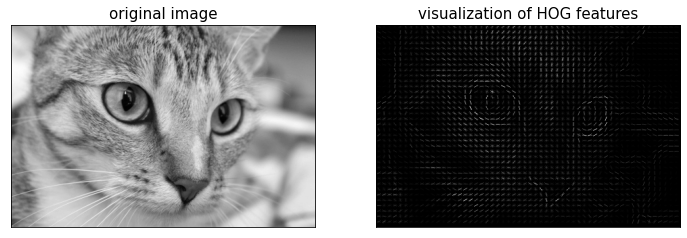

In [2]:
'visualization of HOG features'

image = color.rgb2gray(data.chelsea()) #load an image
hog_vec, hog_vis = feature.hog(image,visualize=True) #extract HOG features

'plot image and hog features'
fig, ax = plt.subplots(1,2, figsize = (12,6),
                       subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(image,cmap='gray')
ax[0].set_title('original image',fontsize=15)

ax[1].imshow(hog_vis,cmap = 'gray')
ax[1].set_title('visualization of HOG features',fontsize=15)

To build our face detector, we need

1. **A set of face images**
2. **A set of nonface images**
3. **To extract the HOG features from all the images**

## A set of face images

We'll use the Labeled Faces in the Wild dataset

In [3]:
#run this cell to load the labeled faces in the wild dataset
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people() 
positive_patches = faces.images/255

positive_patches.shape

(13233, 62, 47)

The positive_patches dataset contains 8211 images, and each image has 2914 (62x47) features. Each feature simply represents one pixel's intensity.

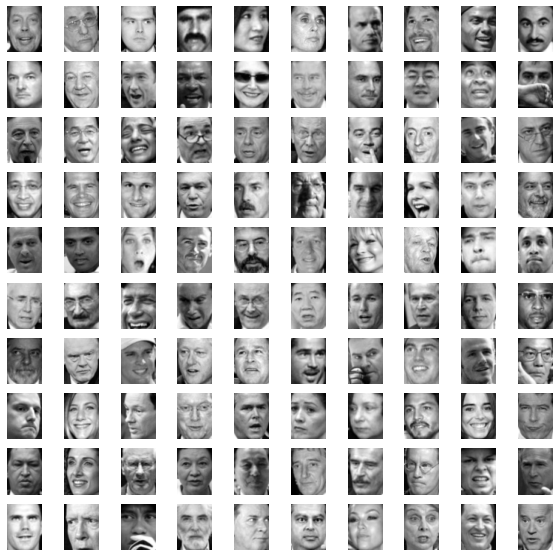

In [4]:
plt.figure(figsize=(10,10))
for i in range(100):
    face_image = positive_patches[i]
    plt.subplot(10,10,i+1)
    plt.imshow(face_image,cmap = 'gray')
    plt.axis('off')

This gives us a sample of 8211 face images.

## A set of nonface images

In [5]:
name = 'camera'
getattr(data,name)().ndim

2

In [6]:
imgs_to_use = ['camera','text','coins','moon','page','clock','immunohistochemistry','chelsea','coffee','hubble_deep_field']
images = [color.rgb2gray(getattr(data,name)())/255 
          if getattr(data,name)().ndim == 3 
          else getattr(data,name)()/255 
          for name in imgs_to_use]

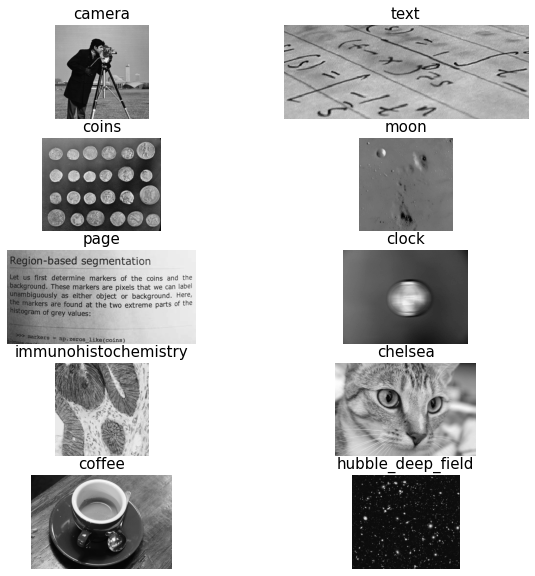

In [7]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(images[i],cmap='gray')
    plt.title(imgs_to_use[i],fontsize=15)
    plt.axis('off')

We'll extract 62x47 thumbnails from these 10 images

In [8]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img,N,scale=1.0,patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale*np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,max_patches=N,random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale !=1:
        patches = np.array([transform.resize(patch,patch_size) for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im,500,scale) for im in images for scale in [1.0, 2.0]])

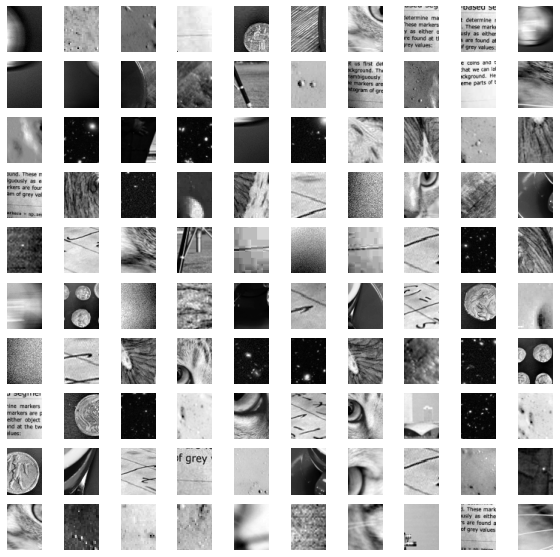

In [9]:
'display 100 (randomly chosen) nonface images'
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(negative_patches[np.random.randint(10000)],cmap='gray')
    plt.axis('off')

In [10]:
negative_patches.shape

(10000, 62, 47)

This gives us a sample of 10,000 nonface images

## Combine sets and extract HOG features

In [11]:
hog_positive_patches = np.array([feature.hog(img) for img in positive_patches])
hog_negative_patches = np.array([feature.hog(img) for img in negative_patches])

'feature matrix'
X = np.r_[hog_positive_patches, hog_negative_patches]

'label vector'
y = np.zeros(X.shape[0]) # 1 = face; 0 = nonface
y[:positive_patches.shape[0]]=1

## Part 1

Fit a logistic regression model to the data

In [14]:
def logregression_GD(X,y,learning_rate, n_epochs=100):
    def sigmoid(t):
        return 1/(1+np.exp(-t))
    def logregression_cost(y,X,theta):
        m = len(y)
        p = sigmoid(X.dot(theta))
        return -(np.sum(y*np.log(p) + (1-y)*np.log(1-p)))

    m,n = X.shape
    theta = np.random.randn(n)
    
    # initialize cost vector 
    cost = np.zeros(n_epochs)
    
    # gradient descent steps
    for epoch in range(n_epochs):
        gradient = X.T.dot(sigmoid(X.dot(theta))-y) # compute gradient
        theta = theta - learning_rate*gradient # Gradient Descent Step
        cost[epoch] = logregression_cost(y,X,theta) # compute the cost function
            
    return theta,cost 

In [29]:
theta,cost, = logregression_GD(X,y, 
                               learning_rate=.00005,
                               n_epochs = 5000,
                              )

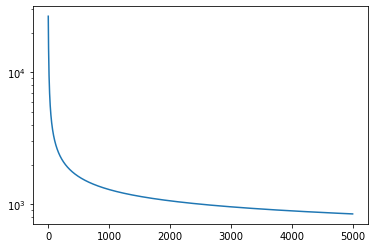

In [30]:
plt.semilogy(cost)

## Part 2

Using the logistic regression model, write a function that classifies a set of images as a face/nonface images.

In [31]:
def face_classifier(X,theta):
    def sigmoid(t):
        return 1/(1+np.exp(-t))
    
    p =  sigmoid(X.dot(theta))
    p[p>0.5]=1
    p[p<=0.5]=0
    
    return p

## Part 3

 Now that we have a logistic regression model in place, let's grab a new image and see how the model does.

(-0.5, 367.5, 183.5, -0.5)

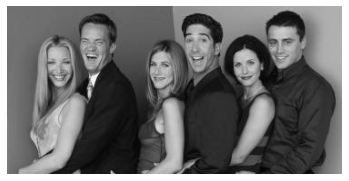

In [32]:
import matplotlib.image as mpimg 
from skimage import io

url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice-bis/master/Classification/Homework/Images/friends.jpg'
new_image = io.imread(url)/255

#new_image = color.rgb2gray(new_image)/255 #transform image into gray scale
plt.imshow(new_image,cmap='gray')
plt.axis('off')

We will pass a sliding window across the image, using the classifier function to evaluate whether that window contains a face or not.

In [33]:
def sliding_window(img,patch_size=positive_patches[0].shape,
                  istep=2,jstep=2,scale=1.0):
    Ni,Nj = (int(scale*s) for s in patch_size)
    for i in range(0,img.shape[0]-Ni,istep):
        for j in range(0,img.shape[1]-Ni,jstep):
            patch = img[i:i+Ni,j:j+Nj]
            if scale !=1:
                patch - transform.resize(patch,patch_size)
            yield(i,j), patch
            
indices, patches = zip(*sliding_window(new_image)) #apply sliding_window to new_image
patches_hog = np.array([feature.hog(patch) for patch in patches]) #extract HOG features

Finally, we can take the HOG features patches and use the classifier function to evaluate whether each patch contains a face.

In [34]:
labels = face_classifier(patches_hog,theta)

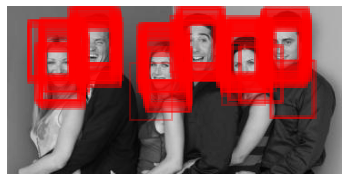

In [35]:
'draw a red rectangle where the classifier function has found a face'
fig, ax = plt.subplots()
ax.imshow(new_image,cmap='gray')
ax.axis('off')

Ni,Nj = positive_patches[0].shape
indices = np.array(indices)
for i,j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj,Ni,edgecolor='red',alpha=0.3,lw=2,facecolor='none'))

## Part 4

Test the face detector on the following image.

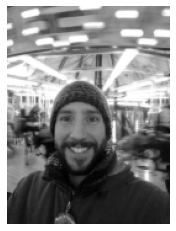

In [37]:
# run this cell to load the image
import matplotlib.image as mpimg 
from skimage import transform
from skimage import io

url = 'https://raw.githubusercontent.com/um-perez-alvaro/log-regress/master/yourfavouriteprofessor.jpg'
new_image = io.imread(url)

new_image = color.rgb2gray(new_image) #transform image into gray scale
s = 3.25 # scale new_image
new_image = transform.resize(new_image, (new_image.shape[0]//s, new_image.shape[1]//s))

plt.imshow(new_image,cmap='gray')
plt.axis('off')
plt.show()

In [38]:
indices, patches = zip(*sliding_window(new_image)) #apply sliding_window to new_image
patches_hog = np.array([feature.hog(patch) for patch in patches]) #extract HOG features

In [39]:
labels = face_classifier(patches_hog,theta)

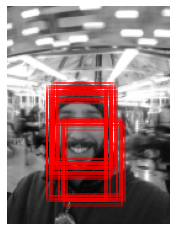

In [40]:
'draw a red rectangle where the classifier function has found a face'
fig, ax = plt.subplots()
ax.imshow(new_image,cmap='gray')
ax.axis('off')

Ni,Nj = positive_patches[0].shape
indices = np.array(indices)
for i,j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj,Ni,edgecolor='red',alpha=0.3,lw=2,facecolor='none'))